# Goal
Explore why the calorimeter data becomes increasingly noisy after 4E3M encoding-decoding: <br>
<img src="mod2.png" width="400">

In [384]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from functools import lru_cache
from bitstring import BitArray

In [385]:
exp_bits = 4
man_bits = 3
max_TCval = (2**man_bits - 1) * 2**(2**exp_bits - 1)
max_TCcode = 2**(man_bits+exp_bits) - 1

@np.vectorize
@lru_cache(128)
def encode(val):
    assert(val >= 0)
    val = np.int32(val)
    bit_len = val.item().bit_length()
    if bit_len <= man_bits:
        return val # special case: return mantissa if value in this range
    if val >= max_TCval:
        return max_TCcode # clip overflow
    
    exp = bit_len - man_bits
    man = val >> exp - 1
    
    ebits = BitArray(uint=exp, length=exp_bits)
    mbits = BitArray(uint=man, length=man.item().bit_length())[1:]
    
    return (ebits+mbits).uint

@np.vectorize
@lru_cache(128)
def decode(code):
    code = int(code)
    assert(code.bit_length() <= man_bits+exp_bits)
    assert(code >= 0)
    
    bits = BitArray(uint=code, length=man_bits+exp_bits)
    ebits = bits[:exp_bits]
    mbits = bits[exp_bits:]
    
    if ebits.uint == 0:
        return mbits.uint
    else:
        return (BitArray('0b1') + mbits).uint << (ebits.uint - 1)

# ADC values and codes
The number of ADC values corresponding to a code increases exponentially. In other words, for small values (up to ADC value 16) the code is identical. After that, the codes start to correspond to increasing ADC values. We can illustrate this by plotting the decoding function over its full range:

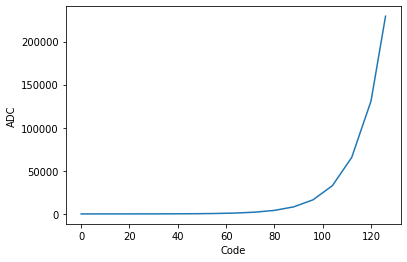

In [386]:
plt.plot(decode(range(max_TCcode)));
plt.xlabel('Code');
plt.ylabel('ADC');

Conversely, we can plot the number of unique ADC values corresponding to a code by iterating over the full range of possible ADC values and encoding it. We see that larger codes correspond to exponentially more ADC values.

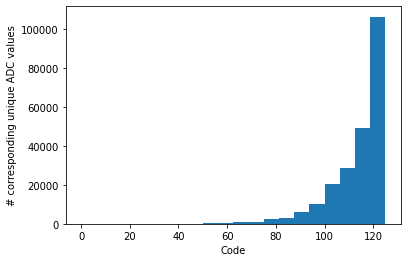

In [489]:
adc = np.array(range(max_TCval))
codes = encode(adc)
plt.hist(codes, bins=20);
plt.xlabel('Code');
plt.ylabel('# corresponding unique ADC values');

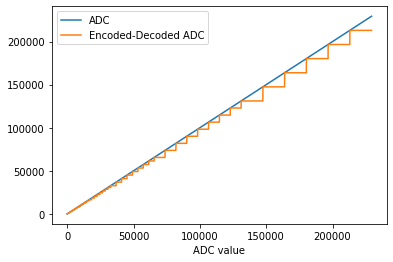

In [490]:
decodes = decode(codes)
plt.plot(adc, adc, label='ADC');
plt.plot(adc, decodes, label='Encoded-Decoded ADC');
plt.xlabel('ADC value');
plt.legend();

We can see that the encoded-decoded ADC values are strictly below the true ADCs.

# Sums of ADC values
Now, for calorimeter data we know that particles cause showers, which are "bright lines" in otherwise dark regions. Looking at a single (EM) shower in one slice of the detector we have a bright spots (of high ADC values) surrounded by otherwise low ADC values (ideally 0). If we are interested in the total energy which was deposited in this detector slice, all we need to do is sum up the pixel values. For the sum it actually doesn't matter where these pixel values are located in the image, only the distribution matters. Thus, to simulate such a distribution we can try sampling from a beta-distribution for $a,b \lt 1$. For these parameters the beta looks like this:

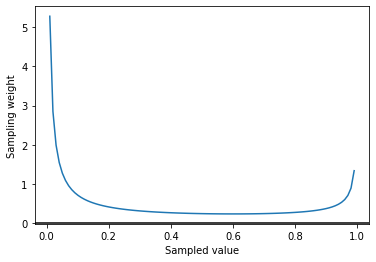

In [387]:
from scipy.stats import beta

x = np.linspace(0,1,100)
a,b = 0.1,0.4
rv = beta(a,b)

plt.plot(x, rv.pdf(x));
plt.axhline(0, c='k');
plt.xlabel('Sampled value');
plt.ylabel('Sampling weight');

Thus, we have very large probability to sample very small values and slightly increased probability to sample around the maximum value, while for the values in between we have relatively low probability. Sampling each pixel value from such a distribution and summing over all pixel values in an image we can simulate the occurance of pixel sums in (real) simulated data:<br>
<img src="mod3.png" width="400">

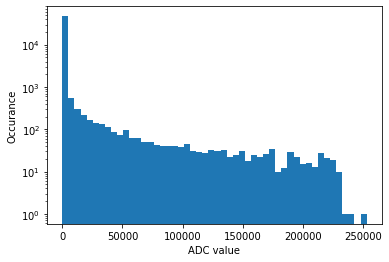

In [482]:
a,b = 0.001,0.99
N = 50_000
W = 4

r = np.random.beta(a,b,size=(N,W,W))
adcs = (r * max_TCval).astype(int)
plt.hist(np.sum(adcs, axis=(1,2)),bins=50);
plt.yscale('log');
plt.xlabel('ADC value');
plt.ylabel('Occurance');

# Sums of codes
If we now encode each pixel value and sum of all codes in an image and subsequently decode again we can see the fluctuations (i.e. the noise) we added by encoding-decoding.

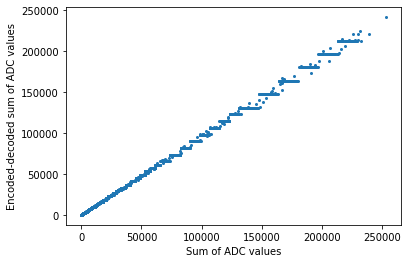

In [485]:
adc_sum = np.sum(adcs, axis=(1,2))
adc_4E3M = decode(encode(adcs))
adc_4E3M_sum = np.sum(adc_4E3M, axis=(1,2))

plt.plot(adc_sum, adc_4E3M_sum, 'o', markersize=2);
plt.xlabel('Sum of ADC values');
plt.ylabel('Encoded-decoded sum of ADC values');

# Result
We can clearly see that the increase in noise is caused by:
1. The fact that we have many very low (near 0) pixels and a few very large (near max_TCval) pixels, i.e. beta-like distributed for $a,b \lt 1$
2. The 4E3M encoding squishes an "exponential" range into a linear one, i.e. it considers exponentially increasing linear "sub-ranges", sees in which range a pixel value falls, rounds it off to the nearest range boundary and takes the encoding that corresponds to this bound. Therefore, for larger pixel values the difference between values which are mapped to the same code can be larger. 
3. As we sum over all pixel values in the end these (exponentially) increasing errors accumulate and finally produce the increasing fluctuations in the encoded sums